In [1]:
import time
import re
from unidecode import unidecode
import pandas as pd
import datetime
from dateutil.parser import parse
from selenium import webdriver
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys

# ======== Task 1 =========
def scrape_data(start_date, from_place, to_place, city_name):
    """
    start_date: a datetime object for the start date that you should use in your query to Google Flight explorer
    from_place: a string with the name of the origin of the flights
    to_place: a string with the name of the regional destination of the flights
    city_name: a string for the name of the city who's data that you should actually scrape
    
    return: a pandas DataFrame object with two columns "Date_of_Flight" and "Price." , and one row for each day
    
    """
    driver = webdriver.Chrome()
    driver.get('https://www.google.com/flights/explore/')
    time.sleep(2)  # wait for the driver to load data
    
    # from_place
    driver.find_elements_by_class_name('LJTSM3-p-a')[0].click()
    ActionChains(driver).send_keys(from_place).perform()
    ActionChains(driver).send_keys(Keys.ENTER).perform()
    time.sleep(1)
    
    # to_place
    driver.find_elements_by_class_name('LJTSM3-p-a')[1].click()
    ActionChains(driver).send_keys(to_place).perform()
    ActionChains(driver).send_keys(Keys.ENTER).perform()
    time.sleep(1)
    
    # start_date
    start_date_str = start_date.strftime("%Y-%m-%d")
    url_date = driver.current_url[:-10] + start_date_str
    driver.get(url_date)
    time.sleep(2)
    
    # use city_name to choose target city
    results_city = driver.find_elements_by_class_name('LJTSM3-v-c')
    city_num = None

    for i in range(len(results_city)):
        city = results_city[i]
        if re.findall(city_name.lower(), unidecode(city.text).lower()):
            city_num = i
    if city_num == None:
        raise Exception('City Name not Found!')    
    time.sleep(1)
    
    # get bars of target city
    results = driver.find_elements_by_class_name('LJTSM3-v-d')
    target = results[city_num]
    bars = target.find_elements_by_class_name('LJTSM3-w-x')
    data = []
    time.sleep(2)

    for bar in bars:
        ActionChains(driver).move_to_element(bar).perform()
        time.sleep(0.01)
        data.append((target.find_element_by_class_name('LJTSM3-w-k').find_elements_by_tag_name('div')[0].text,  # get price
               target.find_element_by_class_name('LJTSM3-w-k').find_elements_by_tag_name('div')[1].text))      # get date of flight

    data = [x for x in data if str(x[0]) != '']  # exclude null bars
    
    # convert into dataframe and return
    clean_data = [(float(d[0].replace('$', '').replace(',', '')), parse(d[1].split('-')[0].strip()))  for d in data]
    df = pd.DataFrame(clean_data, columns=['Price', 'Date_of_Flight'])
    driver.quit()
    return df 
    

In [2]:
from_place = 'Beijing'
to_place = 'Mexico'
start_date = datetime.datetime(2017, 04, 10)
city_name = 'Mexico City'
#city_name = 'Cancun'

data_60 = scrape_data(start_date, from_place, to_place, city_name)
print len(data_60)
data_60.head()

60


,Price,Date_of_Flight
0,965.0,2017-04-10
1,921.0,2017-04-11
2,915.0,2017-04-12
3,934.0,2017-04-13
4,917.0,2017-04-14


### Task 3 question 2

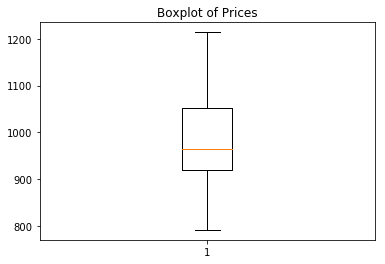

In [31]:
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

flight_data = data_60
plt.boxplot(flight_data['Price'])
plt.title('Boxplot of Prices')
plt.savefig('task_3_iqr.png')

In [32]:
import numpy as np
q1 = np.percentile(flight_data['Price'], 25)
q3 = np.percentile(flight_data['Price'], 75)
IQR = q3 - q1
low_bound = q1-1.5*IQR
outliers = flight_data[flight_data['Price'] < low_bound]

print low_bound
outliers.shape

720.875


(0, 2)

In [35]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

# ======== Task 3 question 2 =========
def task_3_IQR(flight_data):
    df = flight_data
    plt.boxplot(df['Price'])
    plt.title('Boxplot of Prices')
    plt.savefig('task_3_iqr.png')
    
    q1 = np.percentile(df['Price'], 25)
    q3 = np.percentile(df['Price'], 75)
    IQR = q3 - q1
    low_bound = q1-1.5*IQR
    outliers = df[df['Price'] < low_bound]
    if outliers.shape[0] != 0:
        return outliers
    else:
        raise Exception('There is no outlier price!')

Exception: There is no outlier price!

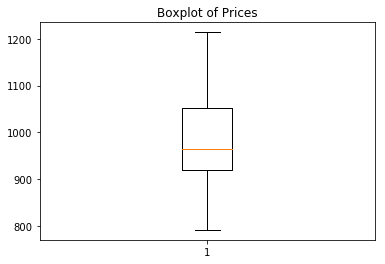

In [36]:
outliers_IQR = task_3_IQR(data_60)
outliers_IQR

### Task 3 question 1

In [89]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np

In [201]:
# clustering
df = data_60
for i in range(len(df)):
    df['Start_Date'][i] = (df['Date_of_Flight'][i]- df['Date_of_Flight'][0]).days +1

X = StandardScaler().fit_transform(df[['Start_Date', 'Price']])
db = DBSCAN(eps=.3, min_samples=3).fit(X)
df['dbscan_labels'] = db.labels_

print X
df

[[-1.7034199  -0.25489224]
 [-1.64567685 -0.70864511]
 [-1.5879338  -0.7705205 ]
 [-1.53019075 -0.57458176]
 [-1.47244771 -0.74989537]
 [-1.41470466 -0.25489224]
 [-1.35696161 -0.25489224]
 [-1.29921857 -0.25489224]
 [-1.24147552 -0.25489224]
 [-1.18373247 -1.14177285]
 [-1.12598942 -0.25489224]
 [-1.06824638 -0.25489224]
 [-1.01050333 -0.25489224]
 [-0.95276028 -0.55395663]
 [-0.89501723 -0.35801789]
 [-0.83727419 -1.00770951]
 [-0.77953114 -0.49208124]
 [-0.72178809 -0.25489224]
 [-0.66404504 -0.25489224]
 [-0.606302   -0.25489224]
 [-0.54855895 -0.78083307]
 [-0.4908159  -0.85302103]
 [-0.43307286  0.02354702]
 [-0.37532981 -1.07989746]
 [-0.31758676 -0.34770533]
 [-0.25984371 -0.85302103]
 [-0.20210067 -1.67802625]
 [-0.14435762 -2.0492786 ]
 [-0.08661457 -0.85302103]
 [-0.02887152  0.62167581]
 [ 0.02887152  0.11636011]
 [ 0.08661457  0.10604755]
 [ 0.14435762 -0.82208333]
 [ 0.20210067 -0.82208333]
 [ 0.25984371 -0.85302103]
 [ 0.31758676 -0.85302103]
 [ 0.37532981 -0.70864511]
 

/Users/xiaowan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Price,Date_of_Flight,Start_Date,dbscan_labels
0,965.0,2017-04-10,1,1
1,921.0,2017-04-11,2,0
2,915.0,2017-04-12,3,0
3,934.0,2017-04-13,4,0
4,917.0,2017-04-14,5,0
5,965.0,2017-04-15,6,1
6,965.0,2017-04-16,7,1
7,965.0,2017-04-17,8,1
8,965.0,2017-04-18,9,1
9,879.0,2017-04-19,10,-1


In [130]:
# result of clustering
labels = db.labels_
clusters = len(set(labels))
unique_labels = set(labels)
print labels
print clusters
print unique_labels

[ 1  0  0  0  0  1  1  1  1 -1  1  1  1  1  1 -1  1  1  1  1  2  2 -1  2 -1
  2 -1 -1  2 -1 -1 -1  2  2  2  2  2  2  2  2 -1  2 -1  3 -1  2  3  2  3 -1
  3  3  3  3  3  3  3 -1 -1 -1]
5
set([0, 1, 2, 3, -1])


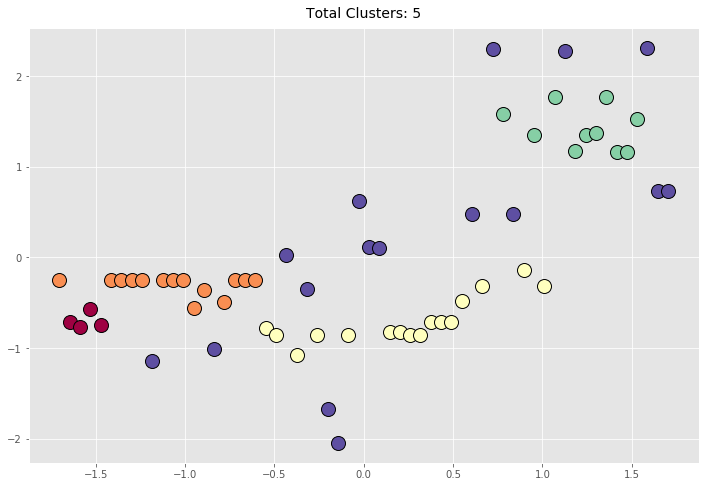

In [131]:
# plot the result of clustering
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

matplotlib.style.use('ggplot')
plt.subplots(figsize=(12,8))

colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
 
for k, c in zip(unique_labels, colors):
    class_member_mask = (labels == k)  # get all the points in class k
    xy = X[class_member_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=c,
            markeredgecolor='k', markersize=14)
 
plt.title("Total Clusters: {}".format(clusters), fontsize=14, y=1.01)
#plt.savefig('task_3_dbscan.png')

In [294]:
# mean of each cluster
mean_points = []
for n in unique_labels:
    x = pd.DataFrame(X)[df.dbscan_labels == n]
    mp = x.mean(axis=0)
    
    d = df[df.dbscan_labels == n]
    m = np.mean(d.Price)
    std = np.std(d.Price)
    thrshd = m - max(2*std,50)
    mean_points.append((n, mp[0], mp[1], m, std, thrshd))

mean_points = pd.DataFrame(mean_points)
mean_points.columns=['Cluster','Start_Date','Price','Mean_Price','Std_Price','Threshould']
mean_points = mean_points[mean_points.Cluster != -1]
mean_points

,Cluster,Start_Date,Price,Mean_Price,Std_Price,Threshould
0,0,-1.559062,-0.700911,921.750000,7.395100,871.750000
1,1,-1.059997,-0.300562,960.571429,9.240550,910.571429
2,2,0.223754,-0.697043,922.125000,23.642850,872.125000
3,3,1.229927,1.420900,1127.500000,21.448776,1077.500000


In [285]:
std_price= []
for n in unique_labels:
    d = df[df.dbscan_labels == n]
    std = np.std(d.Price)
    m = np.mean(d.Price)
    std_price.append((n, m, std))
print std_price[0][1]
std_price

921.75


[(0, 921.75, 7.39509972887452),
 (1, 960.5714285714286, 9.240549502169273),
 (2, 922.125, 23.642850399222173),
 (3, 1127.5, 21.448776188864482),
 (-1, 1013.6875, 124.17664773921867)]

In [212]:
# Outliers
df_outliers = pd.DataFrame(X)[df.dbscan_labels == -1]
df_outliers.columns=['Start_Date', 'Price']
df_outliers

,Start_Date,Price
9,-1.183732,-1.141773
15,-0.837274,-1.007710
22,-0.433073,0.023547
24,-0.317587,-0.347705
26,-0.202101,-1.678026
27,-0.144358,-2.049279
29,-0.028872,0.621676
30,0.028872,0.116360
31,0.086615,0.106048
40,0.606302,0.477300


In [291]:
# find the closest cluster for outlier flights
from scipy.spatial import distance

min_dist_list=[]
nearest_cluster=[]
for j in range(df_outliers.shape[0]):
    outlier = df_outliers.iloc[j]
    dist = []
    for i in range(mean_points.shape[0]):
        mean = mean_points[['Start_Date', 'Price']].iloc[i]
        dist.append(distance.euclidean(outlier,mean))
    min_dist_list.append(min(dist))
    for k, d in enumerate(dist):
        if d == min(dist):
            nearest_cluster.append(k)

print nearest_cluster
min_dist_list

[0, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3]


[0.5789921539509403,
 0.741392587548575,
 0.7057486213718538,
 0.6442726871797768,
 1.0694295963071705,
 1.40144433439152,
 1.3426989124640343,
 0.8364237540348355,
 0.8147162069556212,
 1.1310563514824572,
 1.0176653949178447,
 1.0220355181034213,
 0.8571119544046722,
 0.9611965269296006,
 0.8019662659841272,
 0.8333651590576142]

In [295]:
idx_outliers = outliers.index.tolist()
outliers['closest_cluster'][idx_outliers[4]] # cluster

2

In [315]:
outliers = df_outliers.copy()
outliers = outliers.assign(closest_cluster = pd.Series(nearest_cluster).values,  # Nearest cluster of each outlier
                          orig_Price = df['Price'][df.dbscan_labels == -1])  # Orignal price of each outlier
outliers = outliers.assign(threshould = mean_points['Threshould'][outliers['closest_cluster']].values) # Threshold of the closest cluster
outliers

,Start_Date,Price,closest_cluster,orig_Price,threshould
9,-1.183732,-1.141773,0,879.0,871.750000
15,-0.837274,-1.007710,1,892.0,910.571429
22,-0.433073,0.023547,1,992.0,910.571429
24,-0.317587,-0.347705,2,956.0,872.125000
26,-0.202101,-1.678026,2,827.0,872.125000
27,-0.144358,-2.049279,2,791.0,872.125000
29,-0.028872,0.621676,2,1050.0,872.125000
30,0.028872,0.116360,2,1001.0,872.125000
31,0.086615,0.106048,2,1000.0,872.125000
40,0.606302,0.477300,3,1036.0,1077.500000


### Choose the best epsilon and min_sample value

In [96]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
% matplotlib inline

# ========== Task 3 question 1 ==========
def task_3_dbscan(flight_data, eps_val, min_spl):
    '''
    flight_data: a pandas DataFrame object with 2 columns 'Price' & 'Date_of_Flight', one row for each day
    return: a pandas DataFrame object with 2 colomns 'Price' & 'Date_of_Flight',  one row for each outlier flight
    '''
    df = flight_data
    for i in range(len(df)):
        df['Start_Date'][i] = (df['Date_of_Flight'][i]- df['Date_of_Flight'][0]).days +1
    
    # cluster
    X = StandardScaler().fit_transform(df[['Start_Date', 'Price']])
    db = DBSCAN(eps = eps_val, min_samples = min_spl).fit(X)
    df['dbscan_labels'] = db.labels_
    
    # plot
    labels = db.labels_
    clusters = len(set(labels))
    unique_labels = set(labels)
    colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))
    matplotlib.style.use('ggplot')
    plt.subplots(figsize=(12,8))
    
    for k, c in zip(unique_labels, colors):
        class_member_mask = (labels == k)  # get all the points in class k
        xy = X[class_member_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=c,
                markeredgecolor='k', markersize=14)
 
    plt.title("Total Clusters: {}".format(clusters)+ " Eps={}".format(eps_val)+ " Min_spl={}".format(min_spl), fontsize=14, y=1.01)
    #plt.savefig('task_3_dbscan.png')
    print unique_labels

/Users/xiaowan/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


set([0, 1, 2, 3, -1])


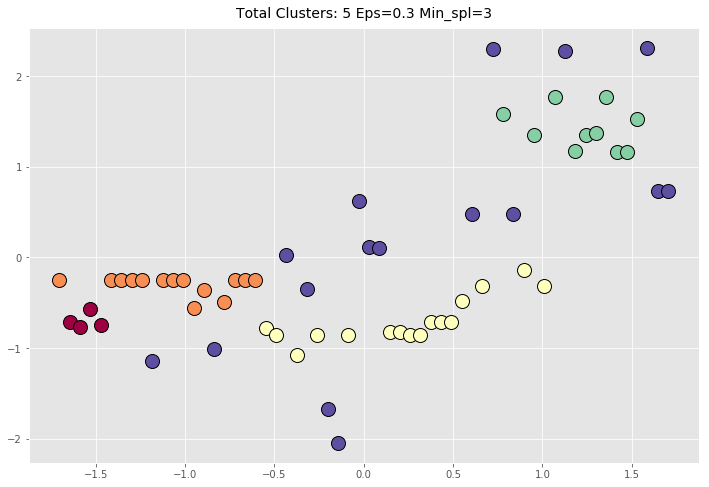

In [97]:
task_3_dbscan(data_60, 0.3, 3)